**Student Name**: B Santhanakrishnan

**Student Roll No**: 21f1003831

# Programming Assignment-2


Make a copy of the colab. Rename the colab as follows:

```
PA-2_<roll-number>.ipynb
```

We will be running your colab. It should produce the graphs/charts as explaind in the problem statements. Add comments wherever necessary. At the end of each problem configuration, enter your observations in the text cell. This should include your analysis of the learning curves obtaind.

### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [27]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [28]:
# import necessary libraries here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from multiprocessing import Pool

In [29]:
import os
os.cpu_count()

12

In [78]:
np.random.seed(0)

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

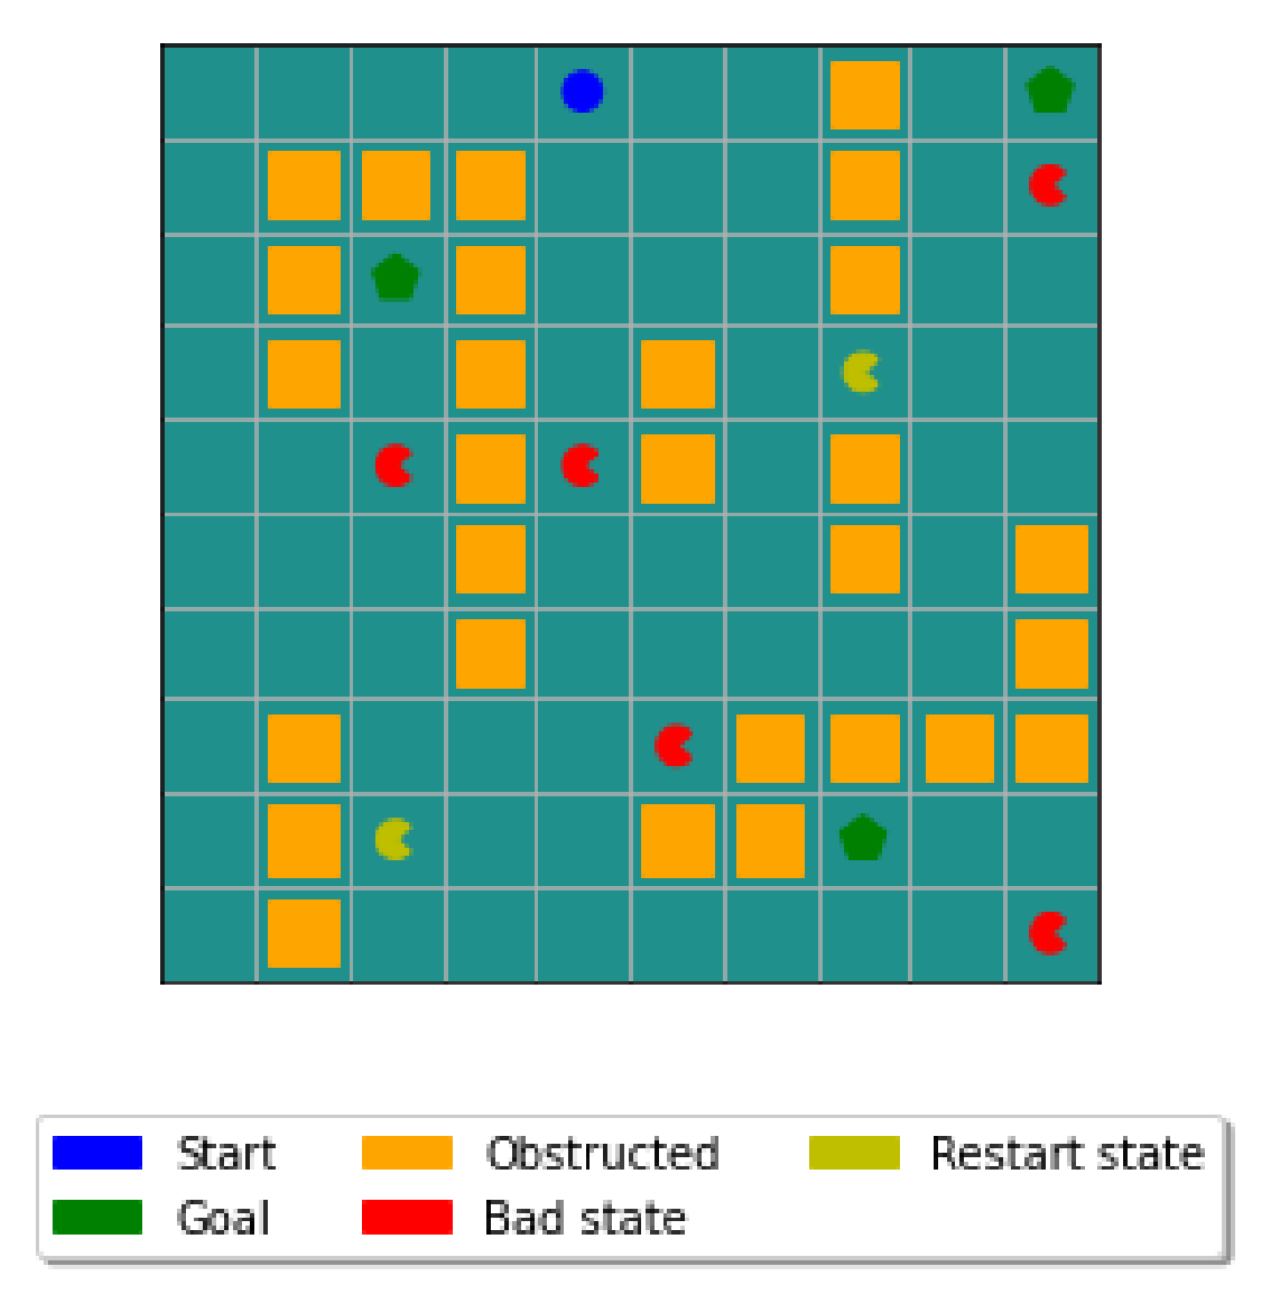

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

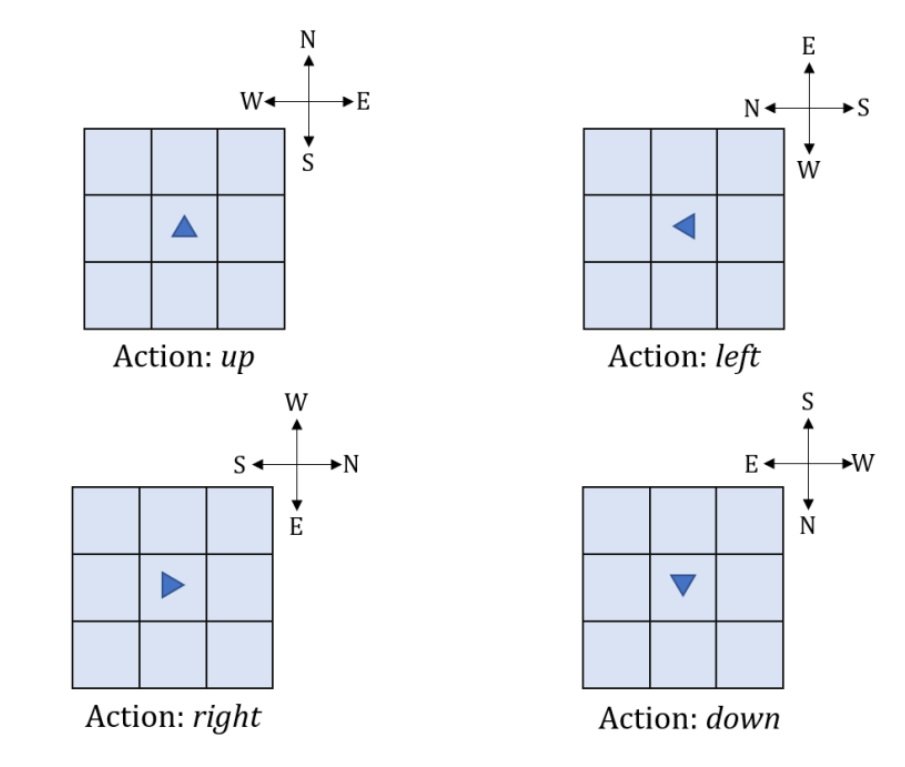

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [30]:
from math import floor
import plotly
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward

    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            p += self.P[state, next_state, action]
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):
          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


In [81]:
def interactive_sample():
    num_cols = 10
    num_rows = 10
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
    restart_states = np.array([[3,7],[8,2]])
    goal_states = np.array([[0,9],[2,2],[8,7]])
    gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=np.array([(0, 4)]),
                goal_states=goal_states,
                wind = False)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

    gw.create_gridworld().visualize_gridworld()
interactive_sample()

## Tasks
- Implement SARSA and Q-Learning.
- ~~For each algorithm, run experiments with wind=False and wind=True; two different start states: (0, 4), (3, 6); two values of $p$ (1.0, 0.7); and two types of exploration strategies ($\epsilon$-greedy and softmax), making it ***16 different configurations*** in total.~~
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

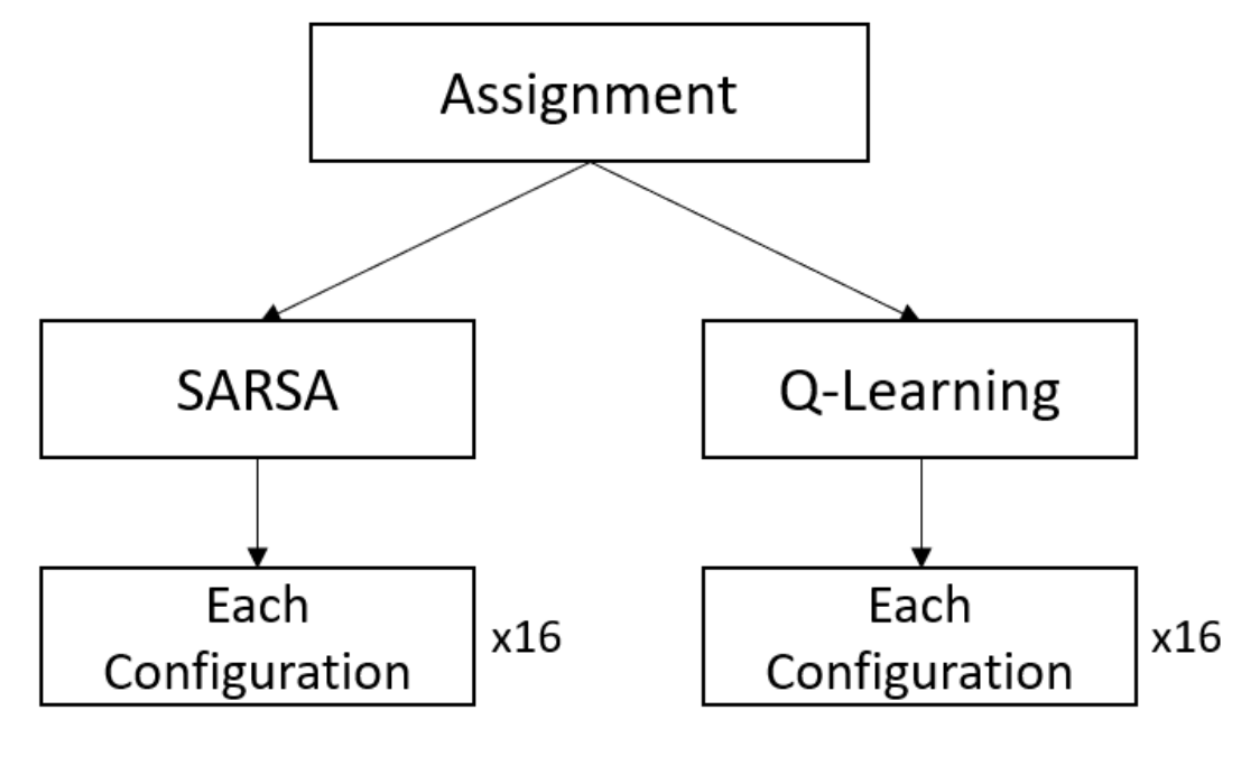

In [31]:
def epsilon_greedy_action(Q_values, epsilon):
    if np.random.rand() < epsilon:
        # Exploration: Choose a random action
        return np.random.randint(len(Q_values))
    else:
        # Exploitation: Choose the action with the highest Q-value
        return np.argmax(Q_values)

def softmax_action(Q_values, temperature):
    probabilities = np.exp(Q_values / temperature) / np.sum(np.exp(Q_values / temperature))
    action = np.random.choice(len(Q_values), p=probabilities)
    return action

In [32]:
def q_learning(environment, exploration_strategy, hyperparams):
    # Extract hyperparameters
    alpha, gamma, exploration_param = hyperparams

    num_runs = 100
    num_episodes = 1000

    # Initialize Q-values
    num_states = environment.num_states
    num_actions = environment.num_actions
    Q = np.zeros((num_states, num_actions))

    # Initialize statistics
    rewards_per_episode = np.zeros((num_runs, num_episodes))
    steps_per_episode = np.zeros((num_runs, num_episodes))
    state_visits = np.zeros((num_runs, num_states))
    optimal_actions = np.zeros((num_runs, num_states))

    for run in range(num_runs):
        for episode in range(num_episodes):
            state = environment.reset()
            total_reward = 0
            total_steps = 0

            while True:
                # Choose action based on exploration strategy
                if exploration_strategy == 'epsilon-greedy':
                    action = epsilon_greedy_action(Q[state, :], exploration_param)
                elif exploration_strategy == 'softmax':
                    action = softmax_action(Q[state, :], exploration_param)
                else:
                    raise ValueError("Invalid exploration strategy")

                # Take action and observe next state and reward
                next_state, reward = environment.step(state, action)

                # Q-learning update
                Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])

                # Update statistics
                total_reward += reward
                total_steps += 1
                state_visits[run, state] += 1

                # Check if the goal is reached or the time steps exceed 100
                if state in environment.goal_states_seq or total_steps >= 100:
                    break

                # Move to the next state
                state = next_state

            # Save statistics for the current episode
            rewards_per_episode[run, episode] = total_reward
            steps_per_episode[run, episode] = total_steps

        # Save optimal actions after each run
        optimal_actions[run, :] = np.argmax(Q, axis=1)

    # Aggregate statistics across runs
    avg_rewards_per_episode = np.mean(rewards_per_episode, axis=0)
    avg_steps_per_episode = np.mean(steps_per_episode, axis=0)
    avg_state_visits = np.mean(state_visits, axis=0)
    avg_optimal_actions = np.mean(optimal_actions, axis=0)

    return {
        'avg_rewards_per_episode': avg_rewards_per_episode,
        'avg_steps_per_episode': avg_steps_per_episode,
        'avg_state_visits': avg_state_visits,
        'avg_optimal_actions': avg_optimal_actions,
        'q_values': Q
    }

In [33]:
def run_single_experiment(config, hyperparams):
    algo, p, wind, start_state, strat = config

    num_cols = 10
    num_rows = 10
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
    restart_states = np.array([[3,7],[8,2]])
    goal_states = np.array([[0,9],[2,2],[8,7]])
    gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=np.array([start_state]),
                goal_states=goal_states,
                wind = wind)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=p,
                                bias=0.5)

    environment = gw.create_gridworld()

    if algo == 'q-learning':
        return q_learning(environment, strat, hyperparams)
    else:
        return sarsa(environment, strat, hyperparams)


In [34]:
def run_experiment(*config):
    *_, strat = config
    alphas = [0.001, 0.01, 0.1, 1.0]
    gammas = [0.7, 0.8, 0.9, 1.0]
    epsilons = [0.001, 0.01, 0.05, 0.1]
    taus = [0.01, 0.1, 1, 2]

    arg_combinations = product([config], product(alphas, gammas, epsilons if strat == 'epsilon-greedy' else taus))

    with Pool() as pool:
        results = pool.starmap(run_single_experiment, arg_combinations)

    best_index = np.argmax([np.mean(result['avg_rewards_per_episode']) for result in results])
    best_results = results[best_index]
    
    return best_results

In [72]:
def plot_reward_curves(result):
    plt.figure(figsize=(8, 6))
    plt.plot(result['avg_rewards_per_episode'])
    plt.title('Average Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')

def plot_num_steps(result):
    plt.plot(result['avg_steps_per_episode'])
    plt.title('Average Number of Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Number of Steps')

    plt.tight_layout()
    plt.show()

def plot_state_visit_counts(results):
    plt.figure(figsize=(8, 8))
    sns.heatmap(results['avg_state_visits'].reshape((10, 10)), annot=True, cmap='YlGnBu', fmt='g')
    plt.title('State Visit Counts')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()

def plot_q_values_and_optimal_actions(results):
    plt.figure(figsize=(12, 6))
    
    # Plot Q Values
    plt.subplot(1, 2, 1)
    sns.heatmap(results['q_values'], cmap='viridis')
    plt.title('Q Values')
    plt.xlabel('Action')
    plt.ylabel('State')

    # Plot Optimal Actions with Arrows
    plt.subplot(1, 2, 2)
    num_rows, num_cols = 10, 10
    arrows = ['↑', '↓', '←', '→']  # Arrow symbols for up, down, left, right

    optimal_actions_symbols = [arrows[int(action)] for action in results['avg_optimal_actions']]
    optimal_actions_grid = np.array(optimal_actions_symbols).reshape((num_rows, num_cols))

    plt.imshow(np.zeros((num_rows, num_cols)), cmap='YlGnBu')  # Blank canvas for plotting arrows

    for i in range(num_rows):
        for j in range(num_cols):
            plt.text(j, i, optimal_actions_grid[i, j],
                     ha='center', va='center', fontsize=12, color='black')

    plt.title('Optimal Actions')
    plt.xlabel('Column')
    plt.ylabel('Row')

    plt.tight_layout()
    plt.show()

## Configurations [64 Marks]

There are total (~~32~~)16 configurations (~~16~~)8 each for SARSA and Q-Learning), each of which carry (~~2~~)4 marks.

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

In [79]:
i = 0
for start_state in (0,4), (3,6):
    for strat in 'epsilon-greedy', 'softmax':
        for p in .7, 1:
            print(f"result{i} = run_experiment('q-learning', {p}, False, {start_state}, '{strat}')")
            i += 1
        for wind in True, False:
            print(f"result{i} = run_experiment('sarsa', 1, {wind}, {start_state}, '{strat}')")
            i += 1

result0 = run_experiment('q-learning', 0.7, False, (0, 4), 'epsilon-greedy')
result1 = run_experiment('q-learning', 1, False, (0, 4), 'epsilon-greedy')
result2 = run_experiment('sarsa', 1, True, (0, 4), 'epsilon-greedy')
result3 = run_experiment('sarsa', 1, False, (0, 4), 'epsilon-greedy')
result4 = run_experiment('q-learning', 0.7, False, (0, 4), 'softmax')
result5 = run_experiment('q-learning', 1, False, (0, 4), 'softmax')
result6 = run_experiment('sarsa', 1, True, (0, 4), 'softmax')
result7 = run_experiment('sarsa', 1, False, (0, 4), 'softmax')
result8 = run_experiment('q-learning', 0.7, False, (3, 6), 'epsilon-greedy')
result9 = run_experiment('q-learning', 1, False, (3, 6), 'epsilon-greedy')
result10 = run_experiment('sarsa', 1, True, (3, 6), 'epsilon-greedy')
result11 = run_experiment('sarsa', 1, False, (3, 6), 'epsilon-greedy')
result12 = run_experiment('q-learning', 0.7, False, (3, 6), 'softmax')
result13 = run_experiment('q-learning', 1, False, (3, 6), 'softmax')
result14 = ru

### (1) Configuration id << insert id>>

#### Configuration Parameters
Learning algorithm =

Wind =

Start State =

Value of $p$ =

Exploration strategy =

Train the agent

In [36]:
result = run_experiment('q-learning', 1, False, (0, 4), 'epsilon-greedy')

1. Plot reward curves (during the training phase with the best hyperparameters).

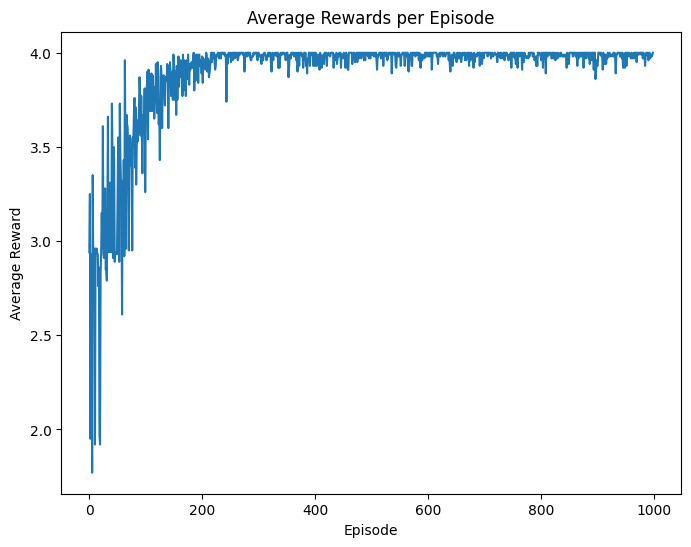

In [58]:
plot_reward_curves(result)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

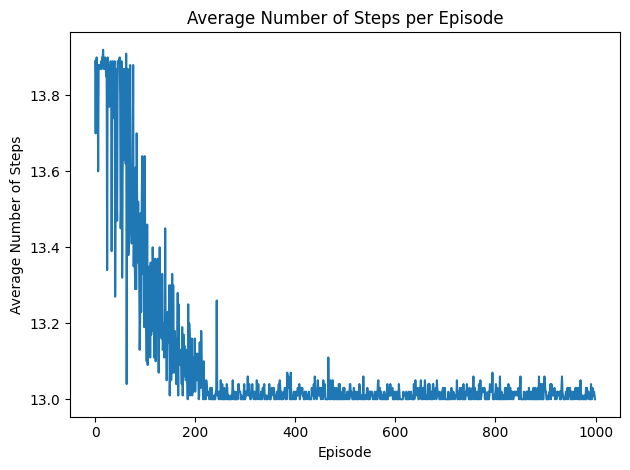

In [59]:
plot_num_steps(result)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

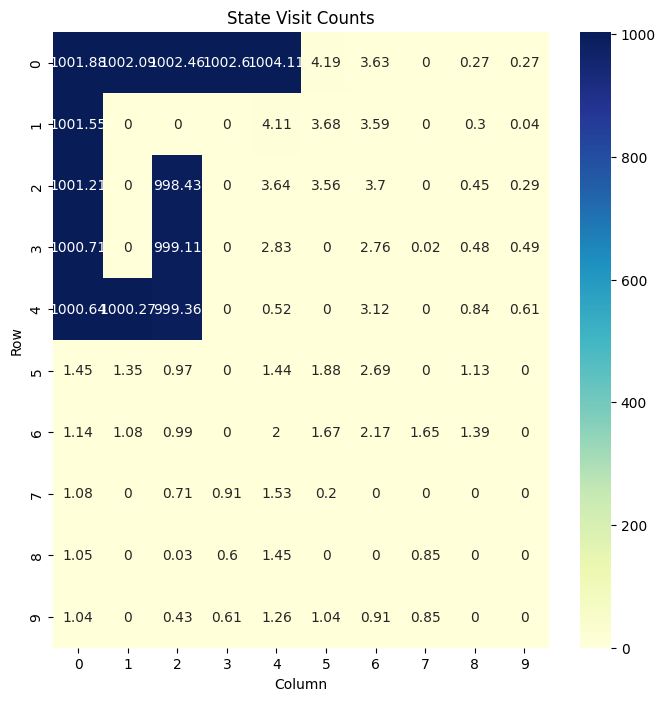

In [60]:
plot_state_visit_counts(result)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

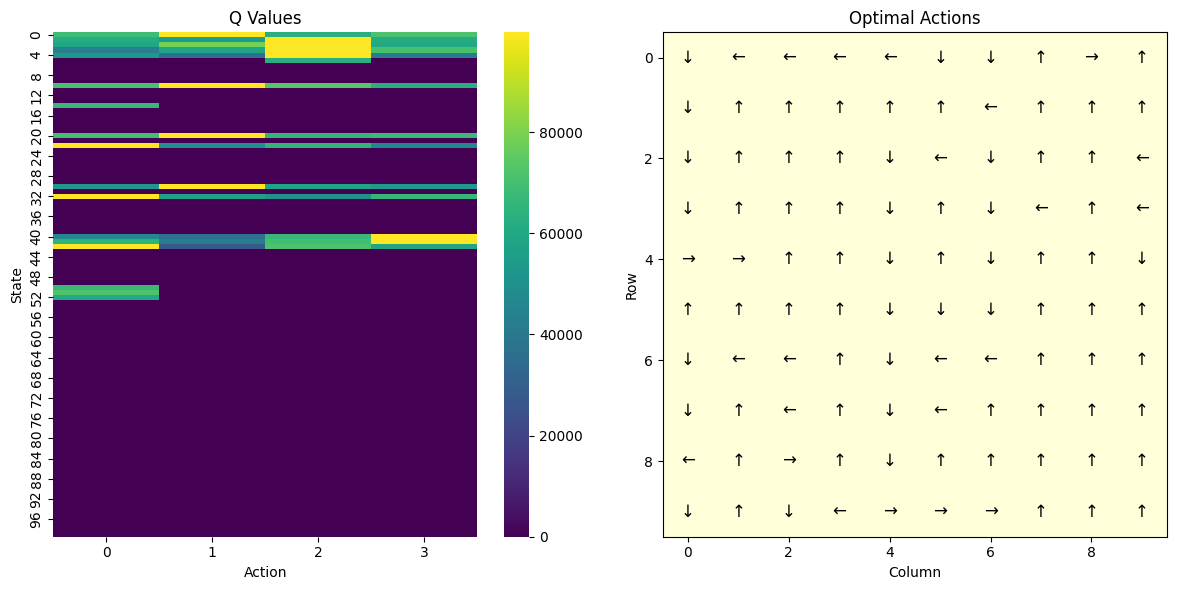

In [73]:
plot_q_values_and_optimal_actions(result)

## Analysis [36 Marks]

### SARSA [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

In [41]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In [42]:
# Optional: any supplementary code

Optional Comments:

### Q Learning [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

In [43]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In [44]:
# Optional: any supplementary code

Optional Comments: